In [329]:
# import the libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline
pd.options.mode.chained_assignment = None  # default='warn'

In [330]:
from math import floor, log10

# define a function that rounds to sig. figs
# https://mattgosden.medium.com/rounding-to-significant-figures-in-python-2415661b94c3
def sig_figs(x: float, precision: int):
    """
    Rounds a number to number of significant figures
    Parameters:
    - x - the number to be rounded
    - precision (integer) - the number of significant figures
    Returns:
    - float
    """

    x = float(x)
    precision = int(precision)

    return round(x, -int(floor(log10(abs(x)))) + (precision - 1))

In [331]:
# File Path
path = "data/B2.csv"

# Axis Labels -- Adjust such that units are appropriate
xlab = "Time, t (s)"
ylab = "P.D., V (V)"

# Enter the values of R and C in Ohms and Farads respectivly
R = 100e3
C = 1e-6

# N is the number of points used to generate the theoretical model
N=100

In [332]:
# Create plot functions
def plotDF(data:pd.DataFrame, xlab, ylab, s=0.1):
    data.plot.scatter(x="t", y="V", s=s)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.xlim(data["t"][0],data['t'].max())
    plt.ylim(0,data["V"].max()+0.1)
    return plt.gcf()

def plotDFAndModel(data, model_data, xlab, ylab, x,y, s=1):
    plt.plot(model_data[x], model_data[y], color="orange")
    plt.scatter(data[x], data[y], s=s)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.xlim(data[x][0],data[x].max())
    plt.ylim(data[y].min()-0.1,data[y].max()+0.1)
    return plt.gcf()

def plotDFAndModelWithRegression(data, model_data, xlab, ylab, x,y, s=5):
    plt.plot(model_data[x], model_data[y], color="orange")
    plt.scatter(data[x], data[y], s=5)
    plt.plot(model_data[x], model_data['regression'], color = "green")
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.xlim(data[x][0],data[x].max())
    plt.ylim(data[y].min()-0.1,data[y].max()+0.1)
    
    return plt.gcf()
    

In [333]:
# read the data
data = pd.read_csv("data/B2.csv")

# Cleaning Data
data = data.drop([0])
data = data.rename(columns={"Time": "t", "Channel A": "V"})

# Converting from string to float
data['t'], data['V'] = data['t'].astype(float), data['V'].astype(float)

# removing 0 values of V:
data = data[data['V'] > 0.09]

# resetting indexes
data = data.reset_index(drop=True)

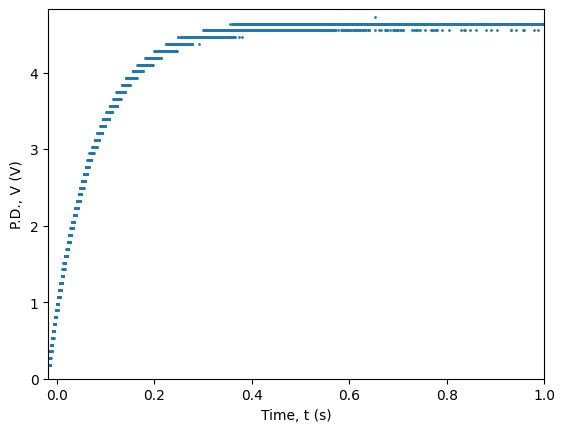

In [334]:
# plot raw data without any models
plot1 = plotDF(data,xlab,ylab, s=1)

# save the plot to a file
plot1.savefig("photos/B/experimental.svg")

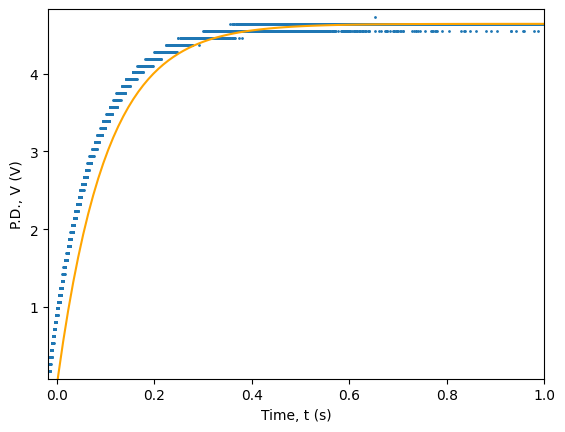

In [335]:
# calculate time constant
𝛕 = R*C

# A loop to determine V0. This ensures that there are at least 10 values that hold the max p.d. ensuring it is not anomalous. If it tries more than 5 values before finding one with more than 10, then it just takes the last value instead.
i = 0
V0 = data['V'].max()
df=data
while i<5:
    if list(df['V']).count(V0)>10:
        break
    
    df = df[df['V'] != V0]
    V0 = df['V'].max()
    i+=1
else:
    V0 = data['V'].tail(1)

# A function to define the theoretical model we are using
def model(x):
    return V0*(1-np.exp(-x/𝛕))

# Creating a new dataframe for the model data with N evenly spaced time values between the max and min times.
model_data = pd.DataFrame()
model_data['t'] = np.linspace(data['t'].min(), data['t'].max(), N)

# Calculate the values of V for the model
model_data['V'] = model(model_data['t'])

# plot the theoretical model and the raw data on the same axis (orange line = theoretical model)
plot2 = plotDFAndModel(data, model_data, xlab, ylab, 't', 'V')

# Save the plot to a file
plot3.savefig("photos/B/theory.svg")

$$
\begin{align}
V&=V_0\left(1-e^{-\frac{t}{\tau}}\right)\\
\implies e^{-\frac{t}{\tau}} &= 1-\frac{V}{V_0}\\
\therefore \ln \left( 1-\frac{V}{V_0} \right) &= \left(-\frac{1}{\tau} \right) t
\end{align}
$$

Therefore a $\ln \left( 1-\frac{V}{V_0} \right)$ against $t$ graph should be a straight line that passes through the origin with gradient $-\frac{1}{\tau}$

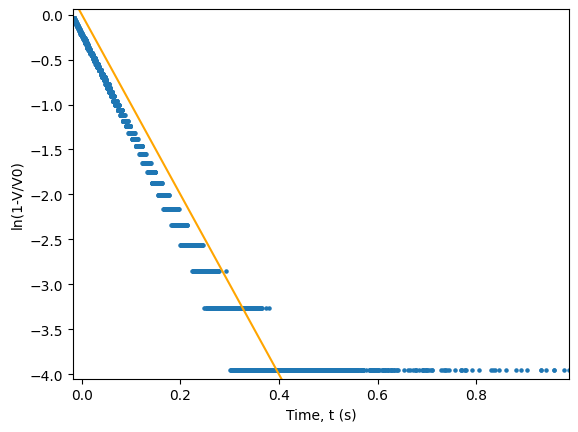

In [336]:
# Calculate the value of 1-V/V0 for all values in the data and model_data frames
data['1-V/V0'] = 1- data['V']/V0
model_data['1-V/V0'] = 1- model_data['V']/V0

# Remove any values of 1-V/V0 that are less than or equal to 0 to avoid errors when performing ln for both dataframes
data = data[(data['1-V/V0']) > 0]
model_data = model_data[model_data['1-V/V0'] > 0]

# Calculate ln of 1-V/V0 and save to the respective data frames
data['ln(1-V/V0)']= np.log(data['1-V/V0'])
model_data['ln(1-V/V0)']= np.log(model_data['1-V/V0'])

# Plot the ln vs t graph for both the data and the model
plot3 = plotDFAndModel(data, model_data, xlab, "ln(1-V/V0)", 't', 'ln(1-V/V0)', s=5)
plot3.savefig("photos/B/ln-theory.svg")

Expected 𝛕: 0.1
Experimental 𝛕: 0.096


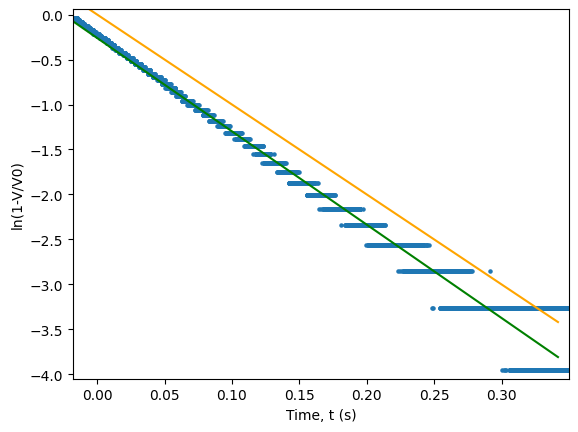

In [337]:
#exclude data above t=0.35 to ensure our line goes through the maximum possible number of points for both dataframes
data = data[data['t']<0.35]
model_data = model_data[model_data['t']<0.35]

# Calculate the coefficients of a linear regression through the dataframe
coeff = np.polyfit(data["t"], data['ln(1-V/V0)'],1)

# Save to a numpy poly1d object for convinience 
p = np.poly1d(coeff)

# Calculate all of values of ln(1-V/V0) for the model and save to a new column in the model_data dataframe
model_data['regression'] = p(model_data['t'])

# Plot the theoretical model, regression line, and experimental data on the same ln(1-V/V0) vs t graph
plot4 = plotDFAndModelWithRegression(data, model_data, xlab, "ln(1-V/V0)", 't', 'ln(1-V/V0)', s=5)

# Save the plot to a file
plot4.savefig("photos/B/regression.svg")

# Print the expected and experimental values of the time constant as calcualted from the inputted data and regression line coefficients respectivly
print("Expected 𝛕:",sig_figs(𝛕,2))
print("Experimental 𝛕:", sig_figs(-1/coeff[0],2))